# Compute $\chi^2$ map on $\sigma_8/\Omega_m$ parameter space for cluster count with SkySim5000 dark matter halo data

## 1. Extract DM haloes from the catalog in a given mass and redshift range.

Authors : Constantin Payerne, Céline Combet

In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.integrate
import astropy.units as u
import GCRCatalogs
from scipy import interpolate
%matplotlib inline
skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')

In [2]:
%%time
# get list of halos in a given redshift and mass range 
mmin_extract = 1.e12 # Msun (M_fof)
zmin_extract = 0.
zmax_extract = 1.0

dm_halos = skysim_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id',
                                             'baseDC2/sod_halo_mass','baseDC2/sod_halo_radius'],
                                            filters=[f'halo_mass > {mmin_extract}','is_central==True',
                                            f'redshift>{zmin_extract}', f'redshift<{zmax_extract}'])

CPU times: user 11.4 s, sys: 16.1 s, total: 27.6 s
Wall time: 29.1 s


NB: SkySim5000 M200c masses are in units of Msun/h

In [3]:
dm_halos['M200c'] = dm_halos['baseDC2/sod_halo_mass']/0.71 # conversion M200c/h -> M200c

In [4]:
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos in this mass (Mfof) and redshift range')

There are 300879 halos in this mass (Mfof) and redshift range


Text(0, 0.5, 'dec [deg]')

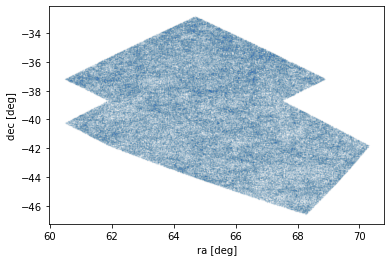

In [5]:
plt.scatter(dm_halos['ra'], dm_halos['dec'], marker='.', s=0.001)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

## 2. 2D binning of the dark matter halo catalog in the $M_{\rm 200c}-z$ plan

In [6]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = np.linspace(0.2, 1, 3)
Z_bin = binning(z_corner)
m_corner = np.logspace(14,14.5, 7)
Mass_bin = binning(m_corner)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


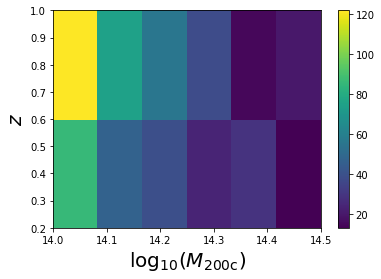

In [7]:
data, mass_edges, z_edges, im  = plt.hist2d(np.log10(dm_halos['M200c']),dm_halos['redshift'], 
                                       bins=[np.log10(m_corner),z_corner], cmin=0);
where_are_NaNs = np.isnan(data)
data[where_are_NaNs] = 0
plt.colorbar()
plt.xlabel(r'$\log_{10}(M_{\rm 200c})$', fontsize = 20)
plt.ylabel(r'$z$', fontsize = 20)
plt.show()

## 3. Computation of the Loglikelihood using CCL Bocquet16 mass functions - ($\Omega_m-\sigma_8$) -plan

The cluster count prediction in redshift bin $i$ and mass bin $j$ is given by :
## $$N_{ij}^{\rm th} = \Omega_{\rm SkySim}\int_{z_i}^{z_{i+1}} dz \frac{dV(z)}{dz d\Omega}\int_{\log_{10}M_j}^{\log_{10}M_{j + 1}}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M$$

We use the Poissonian Log-Likelihood defined as the sum over all the redshift and mass bins :

## $$Log(L)(\Omega_m,\sigma_8) \propto  \sum_{i,j} N_{ij}^{\rm obs}\log( N_{ij}^{\rm th}) -  N_{ij}^{\rm th}$$

### Differential comoving volume

In [8]:
hmd_200c = ccl.halos.MassDef200c()

def dV_over_dOmega_dz(z, cosmo):
    a = 1./(1. + z)
    da = ccl.background.angular_diameter_distance(cosmo, a) 
    E = ccl.background.h_over_h0(cosmo, a)
    return ((1+z)**2)*(da**2)*ccl.physical_constants.CLIGHT_HMPC/cosmo['h']/E

### CCL mass functions

In [9]:
def bocquet16(logm, z, cosmo):
    mass = 10**(logm)
    hmf_200c = ccl.halos.MassFuncBocquet16(cosmo, mass_def=hmd_200c)
    nm = hmf_200c.get_mass_function(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

### Poissonian Log-Likelihood

In [10]:
def logLikelihood_dbquad(Omegam, sigma8):
    
    cosmo = ccl.Cosmology(Omega_c=Omegam - 0.0448, Omega_b=0.0448, h=0.71, sigma8 = sigma8, n_s=0.96)
    
    logL_poissonian = 0
    
    cluster_abundance_obs = np.zeros([len(Mass_bin), len(Z_bin)])
    cluster_abundance_th = np.zeros([len(Mass_bin), len(Z_bin)])
    
    def integrand_bocquet16(logm,z):
        DeltaOmega = 50 * np.pi**2/180**2
        return DeltaOmega * bocquet16(logm, z, cosmo)*dV_over_dOmega_dz(z, cosmo)
    
    for i, m_bin in enumerate(Mass_bin):
        
        for j, z_bin in enumerate(Z_bin):
            
            logm_down, logm_up = np.log10(m_bin)[0], np.log10(m_bin)[1]
            z_down, z_up = z_bin[0], z_bin[1]

            th = scipy.integrate.dblquad(integrand_bocquet16, z_down, z_up, lambda x:logm_down, lambda x:logm_up, epsabs=1.e-4, epsrel=1.e-4)[0]
            
            obs = data[i,j]
            logL_poissonian = logL_poissonian + obs*np.log(th) - th
            
    return logL_poissonian

In [11]:
N_points_Omegam = 10
N_points_sigma8 = 10

Omegam_random = np.linspace(0.2, 0.3, N_points_Omegam)
sigma8_random = np.linspace(0.68, 0.9, N_points_sigma8)

lnL_map = np.zeros([N_points_Omegam, N_points_sigma8])

In [ ]:
%%time

print('computing logLikelihood map ...')

for i, Om in enumerate(Omegam_random):
    
    for j, s8 in enumerate(sigma8_random):
        
        lnL_map[i,j] = logLikelihood_dbquad(Om, s8)

computing logLikelihood map ...


In [ ]:
logLikelihood_data = {'lnL_map': lnL_map, 
                    'Omegam' : Omegam_random, 
                    'sigma8' : sigma8_random, 
                    'cluster_abundance' : data,
                    'redshift_bin' : Z_bin,
                    'Mass_bin' : Mass_bin,}

## 4. Plot $\chi^2 - \chi^2_{\rm min}$ map

Make a 2d interpolation of the $\chi^2  = -2\log(L)$ map. To plot confidence contours on the ($\Omega_m -\sigma_8$) plan, we make a 2D interpolation of $\chi^2 - \chi^2_{\rm min}$.

In [ ]:
def make_chi2_interpolation(lnL_map = 1):
    
    x_down, x_up = min(lnL_map['Omegam']), max(lnL_map['Omegam'])
    y_down, y_up = min(lnL_map['sigma8']), max(lnL_map['sigma8'])
    
    r"plot chi2_map"
    XX, YY = np.meshgrid(lnL_map['Omegam'], lnL_map['sigma8'])

    chi2_map = -2*lnL_map['lnL_map'].T
    minimum = min(chi2_map.flatten())

    r"plot interpolated chi2_map"
    chi2 = interpolate.interp2d(XX, YY, chi2_map - minimum, kind = 'cubic')
    
    omegam = np.linspace(x_down, x_up, 100)
    s8 = np.linspace(y_down, y_up, 100)
    OM, S8 = np.meshgrid(omegam, s8)
    chi_interp = chi2(omegam, s8)

    m = {'chi2':chi2, 
         'chi2_map':[XX, YY, chi2_map - minimum],
         'chi2_map_interp':[OM, S8, chi_interp]}
    
    return m

In [ ]:
chi2 = make_chi2_interpolation(lnL_map = logLikelihood_data)

## 5. Plot $\chi^2$ map versus the cosmoDC2 cosmology
Background : non-interpolated $\chi^2$ map

In [ ]:
plt.figure(figsize = (10,10))
plt.rcParams['axes.linewidth']= 2
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)

plt.contour(chi2['chi2_map_interp'][0], 
                       chi2['chi2_map_interp'][1], 
                       chi2['chi2_map_interp'][2], 
                       colors = 'r', levels = list(np.arange(1,4)**2), linestyles = 'solid')

plt.contourf(chi2['chi2_map'][0], 
                       chi2['chi2_map'][1], 
                       chi2['chi2_map'][2]
                       , linestyles = 'solid', levels = 10)

plt.ylim(min(sigma8_random), max(sigma8_random))
plt.xlim(min(Omegam_random), max(Omegam_random))

plt.vlines(0.2647, 0,2, linestyle = '--', color = 'r', linewidth = 3)
plt.hlines(0.8, 0,2, linestyle = '--', color = 'r', linewidth = 3)

plt.plot([], [], 'r', label = r'1, 2, 3$-\sigma$ contours (interpolation)')
plt.plot([], [], '--r', label = r'cosmoDC2 cosmology')
plt.plot([], [], 'b', )
plt.ylabel(r'$\sigma_8$', fontsize = 30)
plt.xlabel(r'$\Omega_m$', fontsize = 30)
plt.legend(frameon = True, fontsize = 15)
plt.show()

## 5. Posterior distribution for $\Omega_m$ and $\sigma_8$
We plot the quantities
- ## $P(\Omega_m) = \int d \sigma_8 e^{-0.5\chi^2(\Omega_m, \sigma_8)}$ & $P(\sigma_8) = \int d \Omega_m e^{-0.5\chi^2(\Omega_m, \sigma_8)}$

In [ ]:
from scipy.integrate import simps

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (20,10))
plt.rcParams['axes.linewidth']= 2
axs[0].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)

P = np.exp(-0.5*chi2['chi2_map_interp'][2])
Omegam_axis = chi2['chi2_map_interp'][1].T[0]
sigma8_axis = chi2['chi2_map_interp'][0][0]
posterior_Omegam = simps(P, x = sigma8_axis, axis = 0)
posterior_sigma8 = simps(P.T, x = Omegam_axis, axis = 0)

axs[0].plot(sigma8_axis,posterior_Omegam, 'k', linewidth = 3)
axs[0].set_xlabel(r'$\Omega_m$', fontsize = 30)
axs[0].set_ylabel(r'$P(\Omega_m)$', fontsize = 30)
axs[0].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
axs[0].vlines(0.2647, 0,0.011, linestyle = '--', color = 'r', linewidth = 3)
axs[0].set_ylim(0, 0.011)
axs[0].set_xlim(min(Omegam_random), max(Omegam_random))

axs[1].plot(Omegam_axis,posterior_sigma8, 'k', linewidth = 3)
axs[1].vlines(0.8, 0,0.07, linestyle = '--', color = 'r', linewidth = 3)
axs[1].set_xlabel(r'$\sigma_8$', fontsize = 30)
axs[1].set_ylabel(r'$P(\sigma_8)$', fontsize = 30)
axs[1].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
axs[1].set_ylim(0, 0.06)
axs[1].set_xlim(min(sigma8_random), max(sigma8_random))